Reproduce: SimPEG OcTree
=======================

## Simulating Pole-Dipole DC Resistivity Data over a Conductive and a Resistive Block

Pole-dipole DC resistivity data are simulated over both a conductive and a resistive block. The background conductivity is $\sigma_0$ = 0.01 S/m. The conductor has a conductivity of $\sigma_c$ = 0.1 S/m and the resistor has a conductivity of $\sigma_r$ = 0.001 S/m. Both blocks are oriented along the Northing direction and have x, y and z dimensions of 400 m, 800 m and 320 m. Both blocks are buried at a depth of 160 m.

DC voltage data are simulated with a pole-dipole configuration. The survey consists of 9 West-East survey lines, each with a length of 2000 m. The line spacing is 250 m and the electrode spacing is 100 m.

## SimPEG Package Details¶

**Link to the docstrings for the simulation class**.

## Running the Forward Simulation

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from SimPEG import dask
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection, apparent_resistivity
from SimPEG.utils.io_utils import read_dcipoctree_ubc, write_dcipoctree_ubc
from SimPEG import maps, data
from discretize import TreeMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import numpy as np
from pymatsolver import Pardiso

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh, model and survey files for the forward simulation.

In [2]:
# Download .tar

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/dcip/block_model_dc_fwd_simpeg_octree/'
meshfile = rootdir + 'octree_mesh.txt'
confile = rootdir + 'true_model.con'
locfile = rootdir + 'survey.loc'

mesh = TreeMesh.readUBC(meshfile)
conductivity_model = TreeMesh.readModelUBC(mesh, confile)
dc_data = read_dcipoctree_ubc(locfile, 'volt')

Below, we plot the model and the survey geometry used in the forward simulation.

Text(0.5, 1.0, 'Survey Geometry')

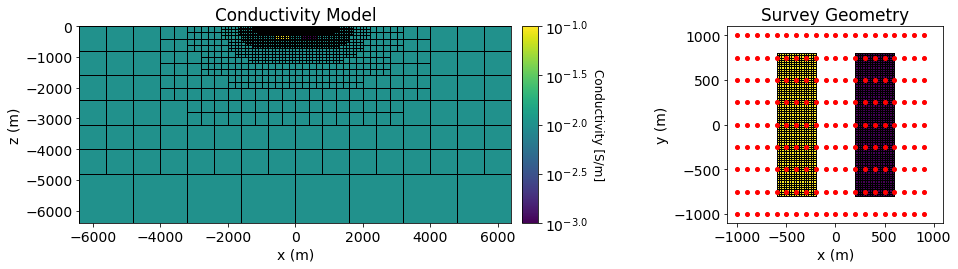

In [4]:
vmin = np.log10(conductivity_model.min())
vmax = np.log10(conductivity_model.max())
ind = int(len(mesh.hy)/2)

fig = plt.figure(figsize=(15, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.4, 0.78])
mesh.plotSlice(
    np.log10(conductivity_model), ax=ax1, normal='Y', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.51, 0.12, 0.015, 0.78])
norm = mpl.colors.Normalize(
    vmin=vmin, vmax=vmax
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.viridis, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

ax3 = fig.add_axes([0.7, 0.12, 0.2, 0.78])
ind = int(len(mesh.hz)-10)
masked_model = np.log10(conductivity_model)
masked_model[masked_model==-2]=np.NaN
mesh.plot_slice(
    masked_model, ax=ax3, normal='Z', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
for ii in range(0, 9):
    ax3.plot(np.arange(-1000, 1000, 100), -1000+ii*250*np.ones(20), 'ro', markersize=4)
ax3.set_xlim([-1100, 1100])
ax3.set_ylim([-1100, 1100])
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_title('Survey Geometry')

Here we define the mapping from the model to the mesh, extract the survey from the data object and define the forward simulation.

In [5]:
model_map = maps.IdentityMap(nP=mesh.nC)

dc_survey = dc_data.survey

dc_simulation = dc.simulation.Simulation3DNodal(
    mesh, survey=dc_survey, sigmaMap=model_map,
    solver=Pardiso, verbose=True, bc_type='Neumann'
)

Homogeneous Neumann is the natural BC for this nodal discretization.


Finally, we predict DC data for the model provided.

In [6]:
dpred_simpeg = dc_simulation.dpred(conductivity_model)

If desired, we can export the simulated DC resistivity data to a UBC formatted data file.

In [7]:
if write_output:
    data_simpeg = data.Data(survey=dc_survey, dobs=dpred_simpeg)
    outname = rootdir + 'dpred_simpeg.txt'
    write_dcipoctree_ubc(outname, data_simpeg, 'volt', 'dpred')
    
    np.random.seed(83)
    standard_deviation = 1e-6 + 0.05*np.abs(dpred_simpeg)
    dobs = dpred_simpeg + standard_deviation * np.random.rand(len(standard_deviation))
    dobs_simpeg = data.Data(survey=dc_survey, dobs=dobs, standard_deviation=standard_deviation)
    outname = rootdir + 'dobs_simpeg.txt'
    write_dcipoctree_ubc(outname, dobs_simpeg, 'volt', 'dobs')

## Plotting Simulated Voltage Data

In [8]:
mpl.rcParams.update({'font.size': 16})

plane_points = []
for x in np.arange(-1000, 1100, 500):
    p1, p2, p3 = np.array([-1000.,x,0]), np.array([1000,x,0]), np.array([1000,x,-1000])
    plane_points.append([p1,p2,p3])

scene_camera=dict(
    center=dict(x=-0.05, y=0, z=-0.2), eye=dict(x=1.1, y=-0.9, z=1.35)
)
scene = dict(
    xaxis=dict(range=[-1000, 1000]), yaxis=dict(range=[-1000, 1000]),
    zaxis=dict(range=[-500, 0]), aspectratio=dict(x=1, y=1, z=0.5)
)

vlim = [dpred_simpeg.min(), dpred_simpeg.max()]

fig1 = plot_3d_pseudosection(
    dc_survey, dpred_simpeg, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='V'
)

fig1.update_layout(
    title_text="Voltage Data", title_x=0.5, width=800, height=700,
    scene_camera=scene_camera, scene=scene
)

plotly.io.show(fig1)

## Plot as Apparent Conductivities

In [9]:
mpl.rcParams.update({'font.size': 16})

app_cond = 1./apparent_resistivity(
    dc_data, space_type="half space", dobs=dpred_simpeg, eps=1e-10,
)

plane_points = []
for x in np.arange(-1000, 1100, 500):
    p1, p2, p3 = np.array([-1000.,x,0]), np.array([1000,x,0]), np.array([1000,x,-1000])
    plane_points.append([p1,p2,p3])

vlim = [app_cond.min(), app_cond.max()]

fig1 = plot_3d_pseudosection(
    dc_survey, app_cond, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='S/m'
)

fig1.update_layout(
    title_text="Apparent Conductivities", title_x=0.5, width=800, height=700,
    scene_camera=scene_camera, scene=scene
)

plotly.io.show(fig1)